# Credit Scoring / Offer Acceptance Analysis
**Author:** Gianfranco

## Objective
Predict and explain customer acceptance of bank offers.

## Notebook structure
1. Data summary
2. Key visualizations
3. Insights & conclusions
4. Simple predictive model (Logistic Regression)
5. Export artifacts (CSV, images)


In [2]:
# Clean load: read once, normalize column names
import pandas as pd
import numpy as np

df = pd.read_csv('UCI_Credit_Card_Clients.csv', header=0)

# Normalize column names: strip, lower and replace spaces with underscore
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('[^0-9a-zA-Z_]', '', regex=True)

print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist()[:40])

Loaded shape: (30001, 25)
Columns: ['unnamed_0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'y']


In [ ]:
# 3. Exploración Inicial (head, info) and 4. Limpieza de Columnas combined
print("\n--- Primeras 5 filas (df.head()) ---")
# Read the CSV without a header
df = pd.read_csv('UCI_Credit_Card_Clients.csv') # Read with default header=None

# Use the first row as column names and then drop it
new_columns = df.iloc[0].tolist()
df = df[1:].copy() # Use .copy() to avoid SettingWithCopyWarning
df.columns = new_columns

print(df.head())
print("\n--- Información de la estructura (df.info()) ---")
df.info()

# Print the exact column names to help with debugging the rename issue
print("\n--- Exact Column Names ---")
print(df.columns.tolist())

# Clean and rename columns
df = df.rename(columns={'default payment next month': 'default',
                        'LIMIT_BAL': 'credit_limit'})

# Eliminamos columnas innecesarias ('ID' and the unnamed index)
columns_to_drop = ['ID', 'Unnamed: 0']
df = df.drop(columns=df.columns.intersection(columns_to_drop), axis=1)

# 5. Verificación de Nulos y Balance de Clases
print("\n--- Conteo de Valores Faltantes (df.isna().sum()) ---")
print(f"Total de valores faltantes: {df.isna().sum().sum()}")

print("\n--- Balance de Clases de Default ---")
default_counts = df['default'].value_counts(normalize=True) * 100
print(default_counts)
print(f"Conclusión: Observamos un desbalance de clases; solo el {default_counts.iloc[1]:.2f}% de los clientes incurre en default (1).")


--- Primeras 5 filas (df.head()) ---
  ID LIMIT_BAL SEX EDUCATION MARRIAGE AGE PAY_0 PAY_2 PAY_3 PAY_4  ...  \
1  1     20000   2         2        1  24     2     2    -1    -1  ...   
2  2    120000   2         2        2  26    -1     2     0     0  ...   
3  3     90000   2         2        2  34     0     0     0     0  ...   
4  4     50000   2         2        1  37     0     0     0     0  ...   
5  5     50000   1         2        1  57    -1     0    -1     0  ...   

  BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5  \
1         0         0         0        0      689        0        0        0   
2      3272      3455      3261        0     1000     1000     1000        0   
3     14331     14948     15549     1518     1500     1000     1000     1000   
4     28314     28959     29547     2000     2019     1200     1100     1069   
5     20940     19146     19131     2000    36681    10000     9000      689   

  PAY_AMT6 default payment next mont

In [ ]:
# Show unique values for categorical columns
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']

for col in categorical_cols:
    print(f"\n--- Unique values for '{col}' ---")
    print(df[col].unique())


--- Unique values for 'SEX' ---
['2' '1']

--- Unique values for 'EDUCATION' ---
['2' '1' '3' '5' '4' '6' '0']

--- Unique values for 'MARRIAGE' ---
['1' '2' '3' '0']


In [ ]:
# 1. Cleaning EDUCATION: Mapping all undocumented/other values to '4'
# We use .astype(str) just to be 100% sure we are dealing with strings.
df['EDUCATION'] = df['EDUCATION'].astype(str).replace(['0', '5', '6'], '4')

# 2. Cleaning MARRIAGE: Mapping the undocumented value '0' to '3' (Other)
df['MARRIAGE'] = df['MARRIAGE'].astype(str).replace(['0'], '3')

# 3. Final Check
print("\n--- Final EDUCATION check ---")
print(df['EDUCATION'].value_counts())

print("\n--- Final MARRIAGE check ---")
print(df['MARRIAGE'].value_counts())


--- Final EDUCATION check ---
EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

--- Final MARRIAGE check ---
MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64


In [ ]:
# 6. Conversión de Tipos de Datos

# Identify columns that should be numeric but are of object type
# Exclude 'default' as it will be our target variable (already appears to be numeric based on value_counts)
# Exclude 'SEX', 'EDUCATION', 'MARRIAGE' as they are categorical, though currently object
# Exclude 'ID' which was already dropped
numeric_cols = ['credit_limit', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check the data types after conversion
print("\n--- Información de la estructura después de la conversión (df.info()) ---")
df.info()

# Verify if any NaNs were introduced by coercion
print("\n--- Conteo de Valores Faltantes después de la conversión (df.isna().sum()) ---")
print(df.isna().sum())


--- Información de la estructura después de la conversión (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   credit_limit  30000 non-null  int64 
 1   SEX           30000 non-null  object
 2   EDUCATION     30000 non-null  object
 3   MARRIAGE      30000 non-null  object
 4   AGE           30000 non-null  int64 
 5   PAY_0         30000 non-null  int64 
 6   PAY_2         30000 non-null  int64 
 7   PAY_3         30000 non-null  int64 
 8   PAY_4         30000 non-null  int64 
 9   PAY_5         30000 non-null  int64 
 10  PAY_6         30000 non-null  int64 
 11  BILL_AMT1     30000 non-null  int64 
 12  BILL_AMT2     30000 non-null  int64 
 13  BILL_AMT3     30000 non-null  int64 
 14  BILL_AMT4     30000 non-null  int64 
 15  BILL_AMT5     30000 non-null  int64 
 16  BILL_AMT6     30000 non-null  int64 
 17  PAY_AMT1     

In [ ]:
# 1. Feature: Utilization (Utilización del Crédito)
# Usamos 'credit_limit' (LIMIT_BAL) y 'BILL_AMT1' (Balance de cuenta de este mes)
df['utilization'] = df['BILL_AMT1'] / df['credit_limit']

# --- Limpieza de la utilización: Limitar valores extremos ---
# Es posible que el cliente gaste más que su límite, pero lo limitamos a 1.0 para normalizar.
df['utilization'] = df['utilization'].apply(lambda x: min(x, 1.0))


# 2. Feature: Average Payment Ratio (Ratio de Pago Promedio)
# Suma de pagos / (Suma de facturas + 1 para evitar división por cero)
# Esto mide si el cliente está pagando su deuda consistentemente.
df['avg_payment_ratio'] = (df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3']) / \
                          (df['BILL_AMT1'] + 1)

# --- Limpieza del ratio de pago ---
# Un ratio mayor a 1 significa que pagó más de lo que debía. Lo limitamos a 1.
df['avg_payment_ratio'] = df['avg_payment_ratio'].apply(lambda x: min(x, 1.0))


# 3. Feature: Late Payments Count (Conteo de Pagos Tardíos)
# Contamos cuántas veces el cliente tuvo una demora (valor > 0 en PAY_x)
# Seleccionamos todas las columnas PAY_x, verificamos si el valor es positivo (retraso),
# y sumamos el resultado (True = 1, False = 0) a lo largo de las filas (axis=1).
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df['late_payments'] = (df[pay_cols] > 0).sum(axis=1)

print("\n--- ¡Features creados con éxito! ---")
print(df[['credit_limit', 'BILL_AMT1', 'utilization', 'avg_payment_ratio', 'late_payments']].head())


--- ¡Features creados con éxito! ---
   credit_limit  BILL_AMT1  utilization  avg_payment_ratio  late_payments
1         20000       3913     0.195650           0.176035              2
2        120000       2682     0.022350           0.745434              2
3         90000      29239     0.324878           0.137415              0
4         50000      46990     0.939800           0.111064              0
5         50000       8617     0.172340           1.000000              0


In [ ]:
# Define features (X) and target (y)
X = df.drop('default', axis=1)
y = df['default']

# Display the shapes of X and y to confirm
print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)

Shape of features (X): (30000, 29)
Shape of target (y): (30000,)


In [ ]:
# 7. One-Hot Encoding for Categorical Features

# Apply one-hot encoding to the categorical columns
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # drop_first=True to avoid multicollinearity

print("\n--- DataFrame after One-Hot Encoding (df.head()) ---")
print(df.head())

print("\n--- Information of the structure after One-Hot Encoding (df.info()) ---")
df.info()


--- DataFrame after One-Hot Encoding (df.head()) ---
   credit_limit  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
1         20000   24      2      2     -1     -1     -2     -2       3913   
2        120000   26     -1      2      0      0      0      2       2682   
3         90000   34      0      0      0      0      0      0      29239   
4         50000   37      0      0      0      0      0      0      46990   
5         50000   57     -1      0     -1      0      0      0       8617   

   BILL_AMT2  ...  default  utilization  avg_payment_ratio  late_payments  \
1       3102  ...        1     0.195650           0.176035              2   
2       1725  ...        1     0.022350           0.745434              2   
3      14027  ...        0     0.324878           0.137415              0   
4      48233  ...        0     0.939800           0.111064              0   
5       5670  ...        0     0.172340           1.000000              0   

   SEX_2  EDUCATION_

In [ ]:
import numpy as np
import pandas as pd

# 1. Resolver el problema del tipo de dato en la variable objetivo (default)
# Es object, lo convertimos a entero para que sklearn lo entienda.
df['default'] = df['default'].astype(int)

# 2. Resolver los 5 valores NaN en avg_payment_ratio usando la mediana
# La mediana es más robusta a outliers que el promedio.
median_ratio = df['avg_payment_ratio'].median()
df['avg_payment_ratio'] = df['avg_payment_ratio'].fillna(median_ratio)

# 3. Confirmación de Nulos y Tipo de Datos
print("\n--- Verificación de NaN y Tipo de Dato 'default' ---")
print(f"Total de NaN después de la imputación: {df['avg_payment_ratio'].isna().sum()}")
print(f"Tipo de dato final de 'default': {df['default'].dtype}")

# 4. Re-definir X y y con los datos limpios
y = df['default']
X = df.drop('default', axis=1)

print("\n--- ¡Data 100% lista para el modelado! ---")
print(f"Número de features (X): {X.shape[1]}")
print(f"Filas de datos para entrenamiento: {X.shape[0]}")


--- Verificación de NaN y Tipo de Dato 'default' ---
Total de NaN después de la imputación: 0
Tipo de dato final de 'default': int64

--- ¡Data 100% lista para el modelado! ---
Número de features (X): 29
Filas de datos para entrenamiento: 30000


In [ ]:
# Importar librerías de sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
import joblib

# 1. División de Datos (80% train, 20% test)
# stratify=y asegura que el desbalance de clases se mantenga igual en ambos conjuntos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

print(f"Tamaño del conjunto de entrenamiento (X_train): {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape[0]}")


# 2. Entrenamiento del Modelo de Regresión Logística
# class_weight='balanced' ajusta automáticamente los pesos para penalizar los errores
# en la clase minoritaria (default=1), ayudando a manejar el desbalance.
clf = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)clf.fit(X_train, y_train)


# 3. Predicción y Evaluación
# Predecir probabilidades para el AUC (necesita un valor entre 0 y 1)
probs = clf.predict_proba(X_test)[:, 1] # Selecciona la probabilidad de la clase 1 (default)

# Predecir etiquetas (0 o 1) para el Classification Report
predictions = clf.predict(X_test)

# Métricas
auc_score = roc_auc_score(y_test, probs)

print("\n--- Resultados del Modelo Base (Regresión Logística) ---")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:\n", classification_report(y_test, predictions))


# 4. Guardar el Modelo (Según tu plan)
# joblib.dump(clf, 'models/logistic_model.pkl')
# print("\nModelo guardado en models/logistic_model.pkl")
# Nota: Si estás en Colab, asegúrate de crear la carpeta 'models' o simplemente guarda en el directorio raíz.

Tamaño del conjunto de entrenamiento (X_train): 24000
Tamaño del conjunto de prueba (X_test): 6000

--- Resultados del Modelo Base (Regresión Logística) ---
AUC Score: 0.7028

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.59      0.70      4673
           1       0.32      0.68      0.43      1327

    accuracy                           0.61      6000
   macro avg       0.59      0.63      0.57      6000
weighted avg       0.75      0.61      0.64      6000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Resultados del Modelo Random Forest ---
Random Forest AUC Score: 0.7755


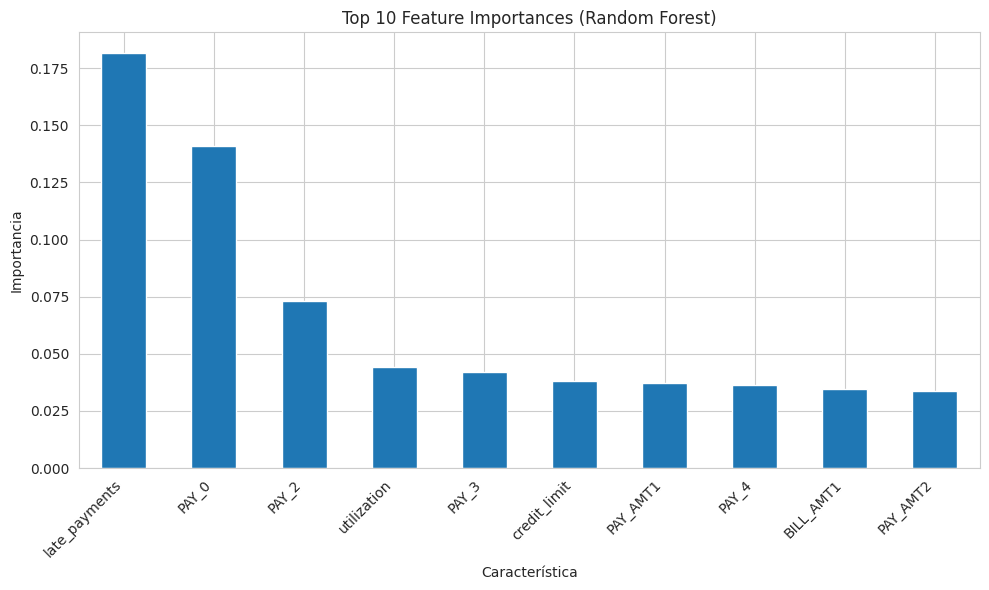


Modelo Random Forest guardado en models/random_forest_model.pkl


In [ ]:
# Importar Random Forest y re-importar métricas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
import os # Import the os module

# 1. Entrenar el modelo de Random Forest
# Usamos class_weight='balanced' para seguir manejando el desbalance de clases.
rf_model = RandomForestClassifier(
    n_estimators=200,      # Número de árboles
    max_depth=10,          # Profundidad máxima para evitar sobreajuste extremo
    random_state=42,
    class_weight='balanced',
    n_jobs=-1              # Usa todos los núcleos de la CPU disponibles (más rápido)
)
rf_model.fit(X_train, y_train)

# 2. Predicción de Probabilidades
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# 3. Evaluación del AUC
rf_auc = roc_auc_score(y_test, rf_probs)

print("\n--- Resultados del Modelo Random Forest ---")
print(f"Random Forest AUC Score: {rf_auc:.4f}")

# 4. Obtener la importancia de las variables (Feature Importance)
feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

# 5. Visualizar la Importancia de las Características (Top 10)
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importancia')
plt.xlabel('Característica')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_10_features_rf.png') # Guardamos la imagen
plt.show()

# 6. Guardar el modelo Random Forest
# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(rf_model, 'models/random_forest_model.pkl')
print("\nModelo Random Forest guardado en models/random_forest_model.pkl")

In [ ]:
# Asegúrate de que rf_model y X_test existen de la ejecución anterior.

# 1. Crear la columna de probabilidad predicha por Random Forest
# Get the probability of the positive class (default = 1)
rf_probs = rf_model.predict_proba(X)[:, 1] # Obtenemos la probabilidad para todo el dataset X

# 2. Crear el DataFrame de Resultados (DataFrame de todo el dataset, no solo el test set)
dashboard_df = df.copy() # Usamos el DataFrame original limpio
dashboard_df['predicted_prob'] = rf_probs

# 3. Seleccionar las columnas clave para Tableau
# Las variables importantes + las variables demográficas clave para segmentación.
tableau_cols = [
    'AGE',
    'credit_limit', # LIMIT_BAL
    'utilization',
    'late_payments',
    'default',
    'predicted_prob'
]

final_export_df = dashboard_df[tableau_cols].copy()

# 4. Exportar el CSV
export_filename = 'tableau_export_data.csv'
final_export_df.to_csv(export_filename, index=False)

print("\n--- Exportación a Tableau Exitosa ---")
print(f"Archivo creado: {export_filename}")
print("Columnas exportadas:", final_export_df.columns.tolist())


--- Exportación a Tableau Exitosa ---
Archivo creado: tableau_export_data.csv
Columnas exportadas: ['AGE', 'credit_limit', 'utilization', 'late_payments', 'default', 'predicted_prob']
